### Keras training
This notebook was used to train our Keras model to predict the upcoming bitcoin prices.

In [146]:
# Tensorflow imports
# from tensorflow.test import is_gpu_available
from tensorflow.keras.models import Sequential, load_model, model_from_json, Model
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers, regularizers

# Sklearn imports
from sklearn.preprocessing import Normalizer, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

# Mongo
from pymongo import MongoClient

# Pandas and numpy
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(18, 4)})

# Hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, STATUS_FAIL, Trials, space_eval, rand

# Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Other
from scipy.ndimage.filters import gaussian_filter1d
from IPython.display import Image
from datetime import datetime, timedelta
from math import sqrt
from keras_tqdm import TQDMNotebookCallback 

import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" 

In [147]:
sns.set(rc={'figure.figsize':(18, 4)})

### Connect to mongo database

In [148]:
# Mongo client
client = MongoClient('mongodb://165.22.199.122:27017')
db = client.processed
data = db.internal

In [150]:
# Load the data
df= (pd.DataFrame(list(data.find()))
    .drop(['_id', 'window'], 1)
    .set_index('timestamp')
    .sort_index()
    .dropna())

# Get the difference in price
df['price_diff'] = df['price'].diff(1)

# Predict two windows forward
df['price_lag'] = df['price'].shift(-2)

# Drop all empty rows
df = df.dropna()

# Price difference cannot be too high, the server went offline a couple times, this fixes the missing data
df = df[df['price_diff'].abs() < 40]

# Ignore the first and last windows
df = df.iloc[3:-3]

df.head()

,n_tweets,price,sentiment,price_diff,price_lag
timestamp,,,,,
2019-11-03 15:05:00,315,9182.618,0.122688,-11.424,9209.472
2019-11-03 15:10:00,243,9199.084,0.144430,16.466,9201.658
2019-11-03 15:15:00,224,9209.472,0.151962,10.388,9201.928
2019-11-03 15:20:00,247,9201.658,0.134234,-7.814,9215.040
2019-11-03 15:25:00,255,9201.928,0.166929,0.270,9212.718


### Function to create timeline plot

In [102]:
def plot_timeline(first_feature, second_feature):
    sns.set_style("dark")
    
    fig, ax1 = plt.subplots()

    ax1.plot(df['2019-01-02 08:00:00':][first_feature], label=first_feature)
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx()
    ax2.plot(df['2019-01-02 08:00:00':][second_feature], color='orange', label=second_feature)
    ax2.legend(loc='upper right')

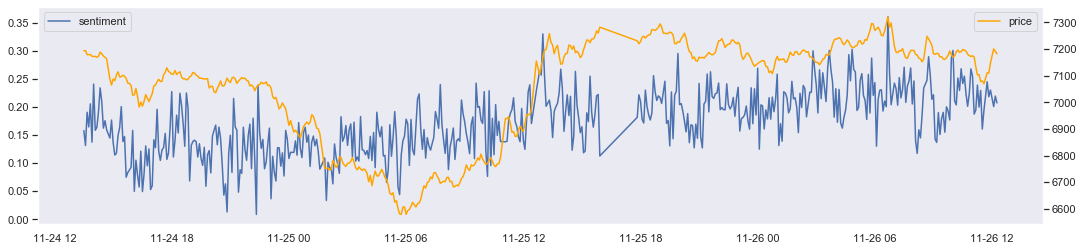

In [103]:
plot_timeline('sentiment', 'price')

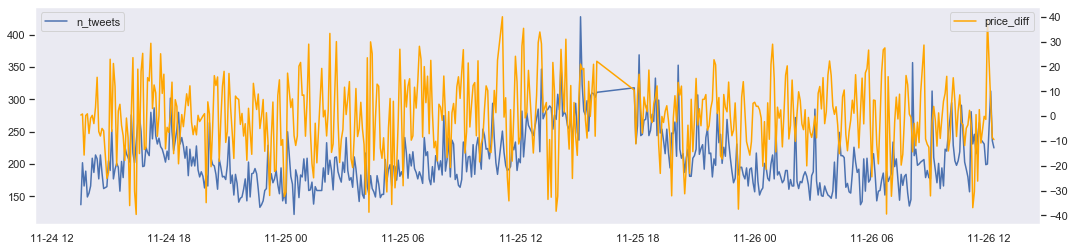

In [104]:
plot_timeline('n_tweets', 'price_diff')

### Prepare training data

In [105]:
np.set_printoptions(suppress=True)

In [106]:
def split_sequence(sequence, n_steps):
    X = []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
        
    return np.array(X)

def generate_train_test(n_steps=12, train_size=.9, flatten=True):
    train_size = int(train_size * len(df))
    
    prices = df['price'].values
    prices_train, prices_test = prices[:train_size], prices[train_size:]
    
    price_diff = df['price_diff'].values
    price_diff_train, price_diff_test = price_diff[:train_size], price_diff[train_size:]
    
    sentiment = df['sentiment'].values
    sentiment_train, sentiment_test = sentiment[:train_size], sentiment[train_size:]
    
    n_tweets = df['n_tweets'].values
    n_tweets_train, n_tweets_test = n_tweets[:train_size], n_tweets[train_size:]
    
    train = np.stack([prices_train, sentiment_train, n_tweets_train], axis=1)
    test = np.stack([prices_test, sentiment_test, n_tweets_test], axis=1)
    
    # Scale the data
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    scaler_mean = scaler.mean_
    scaler_var = scaler.var_
    
    # Create the sequence
    X_train = split_sequence(train_scaled, n_steps)
    X_test = split_sequence(test_scaled, n_steps)
    
    y_prices = df['price_lag']

    y_train = y_prices.iloc[n_steps:len(X_train)+n_steps].values
    y_test = y_prices.iloc[-len(X_test):].values
    
    # Flatten the timeseries
    if flatten:
        X_train = X_train.reshape(-1, X_train.shape[1]*X_train.shape[2], order='F')
        X_test = X_test.reshape(-1, X_test.shape[1]*X_test.shape[2], order='F')
        
    return X_train, X_test, y_train, y_test, scaler_mean, scaler_var

In [107]:
X_train, X_test, y_train, y_test, scaler_mean, scaler_var = generate_train_test(4)

In [108]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((364, 12), (154, 12), (364,), (154,))

In [151]:
# Values to use in our custom standardizer in spark
scaler_values[0], np.sqrt(scaler_values[1])

(array([9099.39552025,    0.17428146,  195.78126582]),
 array([234.32300338,   0.04608954,  52.35318958]))

### Build the keras model

In [66]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true))) 

def build_lstm_model():
    model = Sequential()
    
    model.add(LSTM(32, activation='relu', input_shape=(3, 4)))
    model.add(Dense(16, activation='relu'))
    
    model.add(Dense(1))
    model.compile(optimizer='rmsprop', loss=root_mean_squared_error)
    
    return model

def build_model():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1],)))
    
    model.add(Dense(32, activation='relu'))
        
    model.add(Dense(1))
    model.compile(optimizer='adam', loss=root_mean_squared_error)
    
    return model

In [ ]:
# Create the model
model = build_model()

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=32)

# Checkpoints
checkpointer = ModelCheckpoint(filepath='keras_weights.hdf5',
                                   verbose=0,
                                   save_best_only=True)

# Progressbar
progress = TQDMNotebookCallback(leave_inner=False)

# Fit the model
model.fit(
    X_train, 
    y_train, 
    validation_data=(X_test, y_test),
    epochs=256, 
    batch_size=64,
    verbose=1,
    callbacks=[checkpointer, early_stopping]);

### Load model

In [83]:
def load_trained_model():
    model = build_model()
    model.load_weights('keras_weights.hdf5')
    
    return model

model = load_trained_model()

#### Baseline functions
* Roll - always predict previous price
* Zero - always predict zero

In [84]:
def rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

def predict_roll(data):
    return sqrt(mean_squared_error(np.roll(data, 1)[1:], data[1:]))

def predict_zero(data):
    return sqrt(mean_squared_error(np.zeros_like(data), data))

In [85]:
# Predict using the test data
y_hat = model.predict(X_test)
y_hat_train = model.predict(X_train)

In [86]:
# Test baseline
print('Test baseline roll: ${:.2f}'.format(predict_roll(y_test)))
print('Test baseline zero: ${:.2f}'.format(predict_zero(y_test)))
print('Test RMSE: ${:.2f}'.format(rmse(y_hat, y_test)))

Test baseline roll: $17.93
Test baseline zero: $7195.53
Test RMSE: $846.84


In [87]:
# Train baseline
print('Train baseline roll: ${:.2f}'.format(predict_roll(y_train)))
print('Train baseline zero: ${:.2f}'.format(predict_zero(y_train)))
print('Train RMSE: ${:.2f}'.format(rmse(y_hat_train, y_train)))

Train baseline roll: $34.51
Train baseline zero: $8862.97
Train RMSE: $1803.32


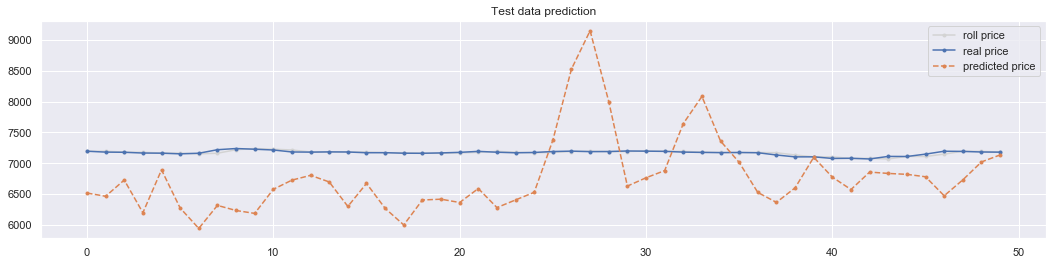

In [88]:
sns.set(style='darkgrid')
plt.plot(np.roll(y_test, 1)[-50:], label='roll price', color='lightgray', marker='o', markersize=3)
plt.plot(y_test[-50:], label='real price', marker='o', markersize=3)
plt.plot(y_hat[-50:], linestyle='dashed', label='predicted price', marker='o', markersize=3)
plt.title('Test data prediction')
plt.legend();

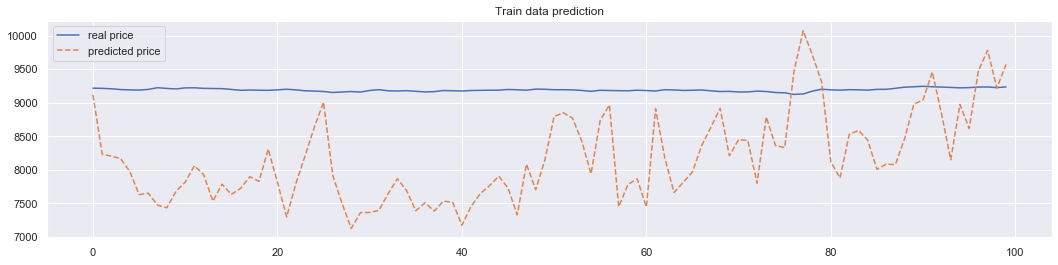

In [89]:
sns.set(style='darkgrid')
plt.plot(y_train[:100], label='real price')
plt.plot(y_hat_train[:100], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();

## Hyperopt

In [90]:
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def build_model(dense_layers=2, dense_hidden_size=8, dropout_rate=0, l1_reg=0, l2_reg=0, 
                optimizer_function='adam', learning_rate=0.001, **arg):
    model = Sequential()
    model.add(Dense(dense_hidden_size, activation='relu', input_shape=(X_train.shape[1],),
                    kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
    model.add(Dropout(dropout_rate))
    
    for layer in range(dense_layers-1):
        model.add(Dense(dense_hidden_size, activation='relu', 
                        kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg)))
        model.add(Dropout(dropout_rate))
        
    model.add(Dense(1))
    
    model.compile(optimizer=optimizer_function, loss=root_mean_squared_error)
    
    return model    

In [91]:
space = {'dense_layers': hp.choice('dense_layers', [1, 2, 3]),
         
         'dense_hidden_size': hp.choice('dense_hidden_size', [8,16,32,64]),
         
         'regularization': hp.choice('regularization', 
                                     [{'reg_type': 'dropout',
                                       'dropout_rate': hp.choice('dropout_rate', [0.20, 0.35, 0.50])},
                                       {'reg_type': 'l1', 
                                        'l1_reg': hp.loguniform('l1_reg', -9, -2)}, 
                                       {'reg_type': 'l2', 
                                        'l2_reg': hp.loguniform('l2_reg', -9, -2)}]),
         
         'optimizer_function': hp.choice('optimizer_function', ['adam', 'RMSprop'])}

In [111]:
def hyperopt_wrapper(params):
    model = build_model(**params)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=32)
    
    checkpointer = ModelCheckpoint(filepath='hyperopt_weights.hdf5',
                                   verbose=0,
                                   save_best_only=True)
    
    result = model.fit(X_train, 
                        y_train, 
                        verbose=0,
                        validation_data=(X_test, y_test),
                        epochs=256, 
                        batch_size=64,
                        use_multiprocessing=True,
                        workers=4,
                        callbacks=[checkpointer, early_stopping])
    
    loss = np.amin(result.history['val_loss'])
    
    print('Loss: {0:.2f}'.format(loss))
    return {'loss': loss, 'status': STATUS_OK, 'trained_model': model}  

In [112]:
trials = Trials()
best = fmin(hyperopt_wrapper, 
            space, 
            algo=tpe.suggest, 
            max_evals=15, 
            trials=trials)

Loss: 983.11                                        
Loss: 423.62                                                                
Loss: 7024.46                                                               
Loss: 1370.37                                                               
Loss: 6976.35                                                               
Loss: 1985.62                                                               
Loss: 7074.78                                                               
Loss: 482.96                                                                
Loss: 483.23                                                                
Loss: 6923.56                                                               
Loss: 1070.17                                                                
Loss: 133.22                                                                 
Loss: 6662.73                                                                 
Loss: 1091.63      

In [135]:
model = trials.results[np.argmin([r['loss'] for r in trials.results])]['trained_model']

In [136]:
model.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_117 (Dense)            (None, 64)                832       
_________________________________________________________________
dropout_60 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_118 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_61 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_119 (Dense)            (None, 64)                4160      
_________________________________________________________________
dropout_62 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_120 (Dense)            (None, 1)               

In [137]:
model = Sequential.from_config(config)
model.compile(optimizer='adam', loss=root_mean_squared_error)

In [ ]:
early_stopping = EarlyStopping(monitor='loss', patience=64)

checkpointer = ModelCheckpoint(filepath='keras_weights.hdf5',
                               verbose=0,
                               save_best_only=True)

result = model.fit(X_train, 
                   y_train,
                   validation_data=(X_test, y_test),
                   epochs=512, 
                   batch_size=32,
                   callbacks=[checkpointer, early_stopping])

In [139]:
model.load_weights('keras_weights.hdf5')

In [141]:
# Predict using the test data
y_hat = model.predict(X_test)
y_hat_train = model.predict(X_train)

In [142]:
# Test baseline
print('Test baseline roll: ${:.2f}'.format(predict_roll(y_test)))
print('Test baseline zero: ${:.2f}'.format(predict_zero(y_test)))
print('Test RMSE: ${:.2f}'.format(rmse(y_hat, y_test)))

Test baseline roll: $25.07
Test baseline zero: $7187.39
Test RMSE: $124.89


In [143]:
# Train baseline
print('Train baseline roll: ${:.2f}'.format(predict_roll(y_train)))
print('Train baseline zero: ${:.2f}'.format(predict_zero(y_train)))
print('Train RMSE: ${:.2f}'.format(rmse(y_hat_train, y_train)))

Train baseline roll: $29.00
Train baseline zero: $6993.19
Train RMSE: $25.42


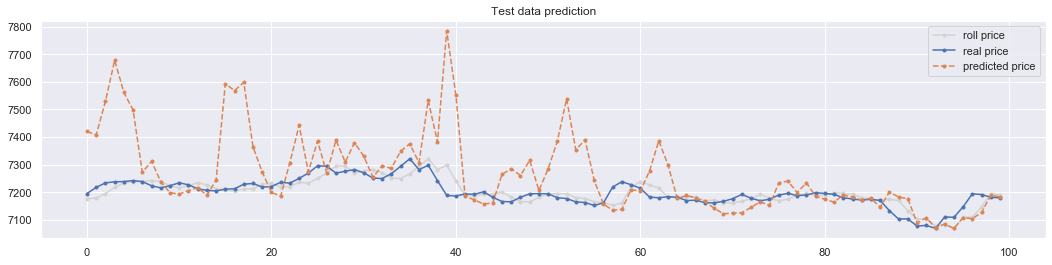

In [144]:
sns.set(style='darkgrid')
plt.plot(np.roll(y_test, 2)[-100:], label='roll price', color='lightgray', marker='o', markersize=3)
plt.plot(y_test[-100:], label='real price', marker='o', markersize=3)
plt.plot(y_hat[-100:], linestyle='dashed', label='predicted price', marker='o', markersize=3)
plt.title('Test data prediction')
plt.legend();

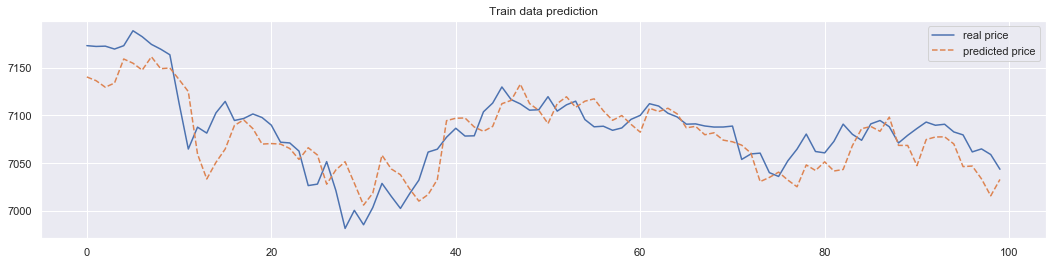

In [145]:
sns.set(style='darkgrid')
plt.plot(y_train[:100], label='real price')
plt.plot(y_hat_train[:100], linestyle='dashed', label='predicted price')
plt.title('Train data prediction')
plt.legend();